<a href="https://colab.research.google.com/github/yashuvishnalia/tensorflow-basic-test-code/blob/master/colab_test0_nifty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving nifty.csv to nifty.csv
User uploaded file "nifty.csv" with length 7092751 bytes


In [5]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "nifty.csv" with length 7092751 bytes


In [38]:
from __future__ import print_function
import pandas as pd

print(pd.__version__)

df = pd.read_csv('nifty.csv',parse_dates=[1])#,date_parser=True)#index_col=False)--not working
df.head()

0.22.0


,date,open,high,low,close,volume
0,2016-01-04 06:30:00+00:00,7832.55,7834.95,7830.00,7834.80,27900.0
1,2016-01-04 06:31:00+00:00,7834.85,7834.90,7830.15,7831.00,21375.0
2,2016-01-04 06:32:00+00:00,7832.8,7833.50,7828.25,7833.25,30150.0
3,2016-01-04 06:33:00+00:00,7833.25,7835.00,7830.80,7832.90,30375.0
4,2016-01-04 06:34:00+00:00,7833.35,7834.70,7831.40,7834.25,15225.0


In [39]:
type(df.date[0])

str

In [41]:
# https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior
df['date'] = pd.to_datetime(df['date'],utc=True)
df.head(2)

,date,open,high,low,close,volume
0,2016-01-04 06:30:00+00:00,7832.55,7834.95,7830.00,7834.8,27900.0
1,2016-01-04 06:31:00+00:00,7834.85,7834.90,7830.15,7831.0,21375.0


In [0]:
df.set_index('date',inplace=True)

In [43]:
df.head()

,open,high,low,close,volume
date,,,,,
2016-01-04 06:30:00+00:00,7832.55,7834.95,7830.00,7834.80,27900.0
2016-01-04 06:31:00+00:00,7834.85,7834.90,7830.15,7831.00,21375.0
2016-01-04 06:32:00+00:00,7832.8,7833.50,7828.25,7833.25,30150.0
2016-01-04 06:33:00+00:00,7833.25,7835.00,7830.80,7832.90,30375.0
2016-01-04 06:34:00+00:00,7833.35,7834.70,7831.40,7834.25,15225.0


In [46]:
type(df.index[0]),len(df)#3months of data

(pandas._libs.tslib.Timestamp, 110371)

In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM,Dense, Activation,Dropout

# For custom metrics
import keras.backend as K

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn import preprocessing

Using TensorFlow backend.


In [51]:
df.close.dtype,df.open.dtype,df.high.dtype,df.low.dtype,df.volume.dtype

(dtype('float64'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'))

In [0]:
df.open=df.open.astype('float64',)

In [55]:
df.open.dtype

dtype('float64')

In [56]:
df['PCT_change']=((df['close']-df['open'])/df['open'])*100
df['HL_PCT']= ((df['high']-df['low'])/df['close'])*100
df_=df[['close','volume','PCT_change','HL_PCT']]
df_['pct']=df['close'].pct_change()
new_order = [0,4,1,2,3]
df_=df_[df_.columns[new_order]]
df_.fillna(0,inplace=True)
df_.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,close,pct,volume,PCT_change,HL_PCT
date,,,,,
2016-01-04 06:30:00+00:00,7834.80,0.000000,27900.0,0.028726,0.063180
2016-01-04 06:31:00+00:00,7831.00,-0.000485,21375.0,-0.049139,0.060656
2016-01-04 06:32:00+00:00,7833.25,0.000287,30150.0,0.005745,0.067022
2016-01-04 06:33:00+00:00,7832.90,-0.000045,30375.0,-0.004468,0.053620
2016-01-04 06:34:00+00:00,7834.25,0.000172,15225.0,0.011489,0.042123


In [0]:
data_=np.array(df_)[0:10000]

In [0]:
scaler=preprocessing.MinMaxScaler().fit(data_)
data = scaler.transform(data_)
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=50)#monitor='val_loss'

In [0]:
def feature_and_label(X,y,back_step=1,forward_step=1):
    X_ = np.array([X[i:i+back_step][:] for i in range(len(X)-back_step+1-forward_step)])#index(0-1009)=len1010
    #for continuous data prediction
#     y_ = np.array([y[i+back_step:i+back_step+forward_step] 
#                    for i in range(len(y)-back_step+1-forward_step)])#index(1-1010)=len1010
    #prediction at forward_step 
    y_ = np.array([y[i+back_step+forward_step-1] 
                   for i in range(len(y)-back_step+1-forward_step)])    
    return X_,y_
def data_prep(data_t,back_step=1,forward=1,batch_size=32):
    ''' change data_t[:,1:2],data_t[:,0] accordingly '''
    X_,y_ = feature_and_label(data_t[:,0:3],data_t[:,0],back_step,forward)
    X_=X_.reshape(len(X_),len(X_[0]),len(X_[0][0]))
    y_=y_.reshape(len(y_),1)#have to change if we have other dimen of y
    print("shape X, y : ",X_.shape,y_.shape,X_[0],y_[0])

    m=int(len(X_)/batch_size)
    ratio=(int(m*0.8))*batch_size
    train_X,test_X=X_[:ratio],X_[ratio:m*batch_size]
    train_y,test_y=y_[:ratio],y_[ratio:m*batch_size]
    print("test x,y and train x, y shape : ",test_X.shape,test_y.shape,train_X.shape,train_y.shape)

    return train_X,train_y,test_X,test_y
def build_neural_net(batch_size,back_step=1,n_feature=1):
    # expected input data shape: (batch_size, timesteps, data_dim)
    model = Sequential()
    model.add(LSTM(128, return_sequences=True,batch_input_shape=(batch_size,back_step, n_feature),
                   stateful=True,))  # returns a sequence of vectors of dimension 32
    model.add(Dropout(0.1))
    model.add(LSTM(256))#, return_sequences=True, stateful=True,))  # returns a sequence of vectors of dimension 32
#     model.add(LSTM())  # return a single vector of dimension 32
    model.add(Dropout(0.1))
    model.add(Dense(64))
    model.add(Dense(1))
#     def mean_pred(y_true, y_pred):
#         return K.mean(y_pred)

    # For a mean squared error regression problem
    model.compile(optimizer='adam',
                  loss='mse',
                 metrics=['accuracy'])#, mean_pred])
    return model
def train(train_X,train_y,back_step,n_feature=1,batch_size=32,model=False):
    if not model:
        model = build_neural_net(batch_size,back_step,n_feature)
    model.fit(train_X,train_y,
          batch_size=batch_size, epochs=75, shuffle=False, verbose=0,
                    callbacks=[early_stop],
#           validation_data=(x_val, y_val)
             )
    return model

def scale_for_c_price(scaler):
    scale=preprocessing.MinMaxScaler()
    scale.min_,scale.scale_=scaler.min_[0],scaler.scale_[0]
    return scale
def pred_plot(pred,test_y,scale):
#     pred = model.predict(test_X)
    plt.figure(figsize=(15,4))
    plt.plot(range(len(pred)),scale.inverse_transform(pred),label='p')
    plt.plot(range(len(test_y)),scale.inverse_transform(test_y),label='y')
    plt.grid()
    plt.legend()
    plt.show()

In [0]:
batch_size=64
back_step=1

In [125]:
train_X,train_y,test_X,test_y = data_prep(data_t=data,back_step=back_step,forward=1,batch_size=batch_size)

shape X, y :  (9999, 1, 3) (9999, 1) [[0.98472321 0.64760332 0.0568    ]] [0.98056179]
test x,y and train x, y shape :  (2048, 1, 3) (2048, 1) (7936, 1, 3) (7936, 1)


In [0]:
# val_loss is for monitoring loss on validation dataset, I think. 
# As you are not feeding the validatation_data to model.fit, 
# there is no way to monitor on val_loss metric.
model = train(train_X,train_y,back_step,n_feature=3,batch_size=batch_size)

In [127]:
loss_and_metrics = model.evaluate(test_X,test_y, batch_size=batch_size)
loss_and_metrics

2048/2048 [==============================] - 0s 226us/sample - loss: 0.0057 - acc: 4.8828e-04


[0.0057362650790082625, 0.00048828125]

for feature close and pct
epoch=25
loss: 0.0332 - acc: 4.8828e-04
--
epoch=35-61 is best range of loss around 0.0002 (note:cumulative loss will be different-see the graph below)
--
when volume is added
 loss: 0.0427 - acc: 0.0000e+00
--
another 25 epoch:-
loss: 0.0045 - acc: 4.8828e-04
--
another 25 epoch:-
loss: 9.0115e-04 - acc: 4.8828e-04
--

In [0]:
pred = model.predict(test_X, batch_size=batch_size)

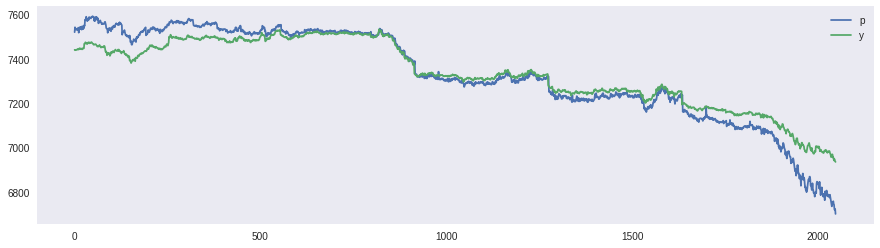

minumum loss: 0.00019611047908314974 
at epoch : (array([61]),)


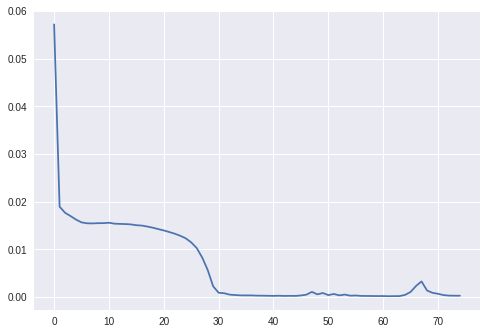

In [121]:
'''epoch = 75 
feature = price,pct
'''
scale=scale_for_c_price(scaler)
pred_plot(pred,test_y,scale)
model_dict = model.history.history
np_loss=np.array(model_dict['loss'])
plt.plot(np_loss)
print('minumum loss: {} '.format(np.amin(np_loss)))
print('at epoch : {}'.format(np.where(np_loss==np.amin(np_loss))))

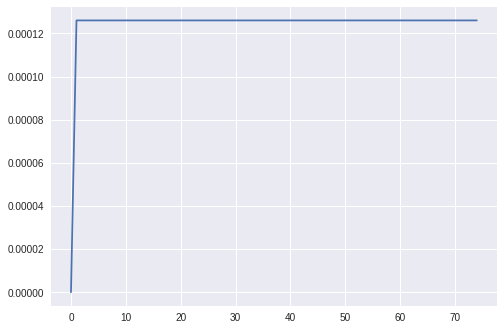

In [122]:
'''
why accuracy isn't changing much
'''
plt.plot(model.history.history['acc'])

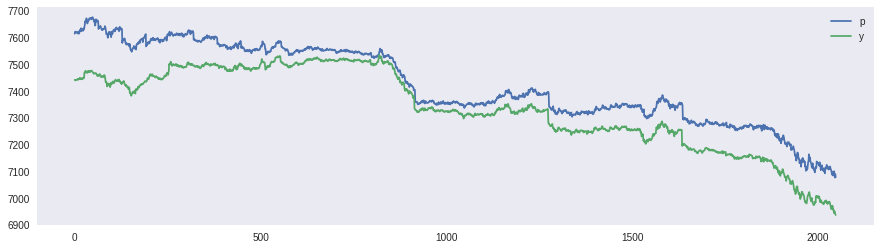

minumum loss: 0.00018599290547905594 
at epoch : (array([61]),)


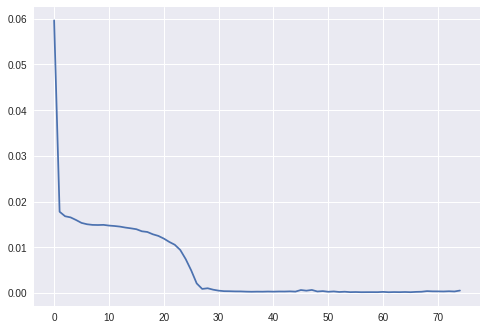

In [129]:
'''epoch = 75 
feature = price,pct,vol
'''
scale=scale_for_c_price(scaler)
pred_plot(pred,test_y,scale)
model_dict = model.history.history
np_loss=np.array(model_dict['loss'])
plt.plot(np_loss)
print('minumum loss: {} '.format(np.amin(np_loss)))
print('at epoch : {}'.format(np.where(np_loss==np.amin(np_loss))))

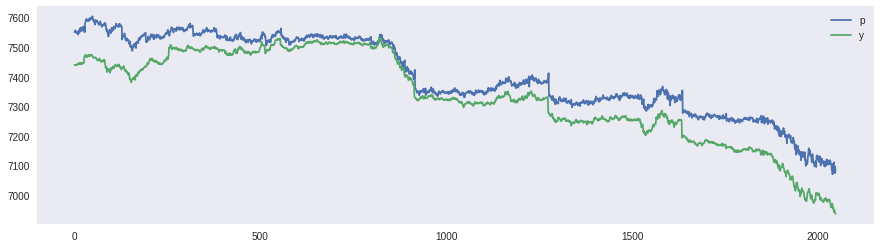

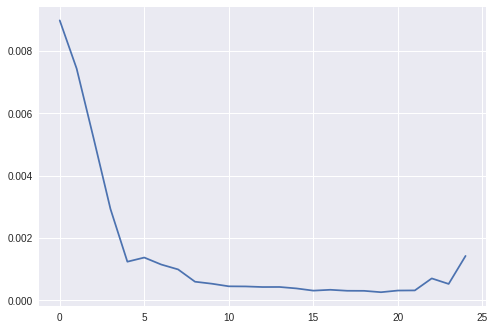

In [97]:
'''epoch = 50 
feature = price,pct,vol
'''
scale=scale_for_c_price(scaler)
pred_plot(pred,test_y,scale)
model_dict = model.history.history
plt.plot(model_dict['loss'])

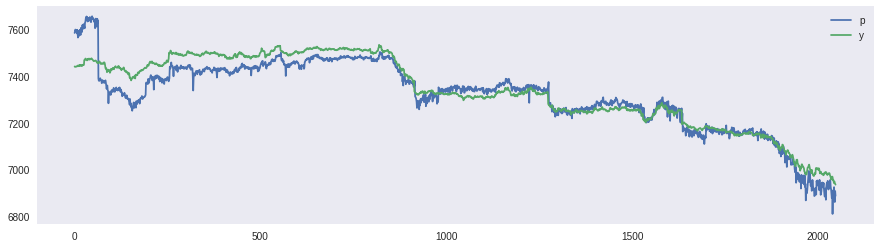

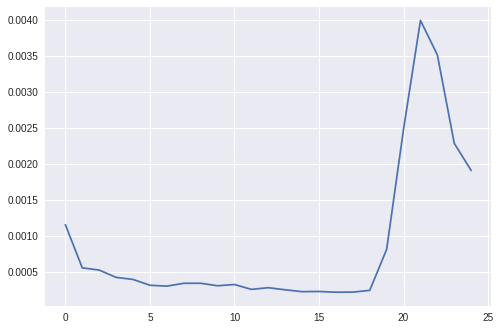

In [101]:
'''
3feature and epoch=75
'''
model_dict['loss'] += model.history.history['loss']
scale=scale_for_c_price(scaler)
pred_plot(pred,test_y,scale)
plt.plot(model_dict['loss'])

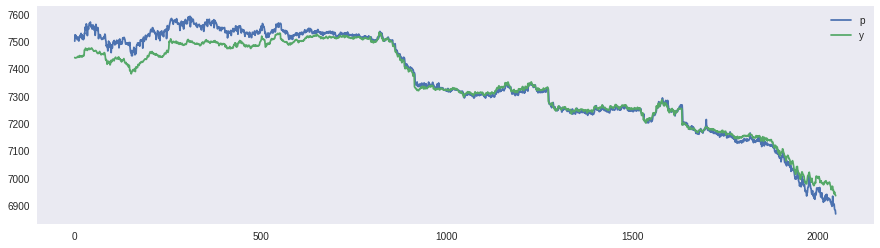

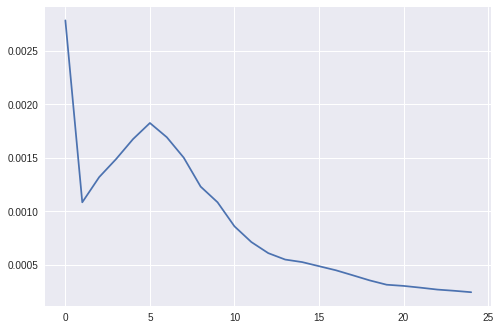

In [109]:
'''
3feature and epoch=100
'''
model_dict['loss'] += model.history.history['loss']
scale=scale_for_c_price(scaler)
pred_plot(pred,test_y,scale)
plt.plot(model.history.history['loss'])

**best result at 65th epoch on this model of price,pct,vol as feature
**

*   lstm128dp(.1)-lstm256dp(.1)-D64-D1-mse


In [132]:
mse, _ = model.evaluate(test_X,test_y, batch_size=batch_size)
rmse = np.sqrt(mse)
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

2048/2048 [==============================] - 0s 63us/sample - loss: 0.0113 - acc: 4.8828e-04
Root Mean Square Error on test set: 0.106


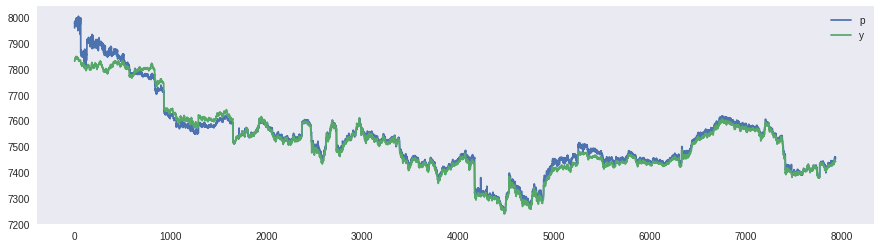

In [110]:
pred = model.predict(train_X, batch_size=batch_size)
scale=scale_for_c_price(scaler)
pred_plot(pred,train_y,scale)

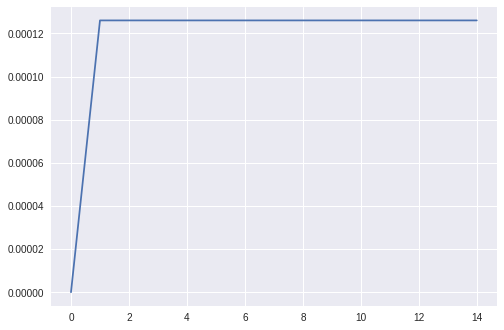

In [67]:
plt.plot(model.history.history['acc'])

In [131]:
x = model.history.epoch
x[-5:]

[70, 71, 72, 73, 74]

In [137]:
for key in model.history.__dict__:
  print(key)

validation_data
model
params
epoch
history
